In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
plt.style.use('seaborn')
from imblearn.over_sampling import SMOTE
import pickle

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Introduction

The following dataset comes from kaggle (url: https://www.kaggle.com/blastchar/telco-customer-churn) which records various attributes of customers and whether or not they disconnected service. The data was likely taken over a 6 year period as the maximum tenure is 72 months. The data contains demographic attributes such as whether the customer has children, has a partner, and is a senior citizen. In addition, payment, billing, and subscribed service information is also included.

The goal of this project is to utilize supervised learning models to accurately predict customer churn. The secondary goal is to identify the leading variables leading to customer attrition and provide information on focus groups.

In [2]:
df = pd.read_csv('file:///C:/Users/JChaotogo/Documents/DataSets/Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Clean the Data

There are a few missing fields in the data and some categorical values that can be simplified. The binary variables will be changed to 0s and 1s for simplicity. For the data that has a third varible such as "No internet service" or "No Phone Service, the information is already captured by the 'Phone Service' and 'InternetService' columns.

In [3]:
df['Churn'] = np.where(df.Churn=='Yes',1,0)
df['female'] = np.where(df.gender=='Female',1,0)
df['haspartner'] = np.where(df.Partner=='Yes',1,0)
df['hasdependents'] = np.where(df.Dependents=='Yes',1,0)
df['hasphoneservice'] = np.where(df.PhoneService =='Yes',1,0)
df['hasmultlines'] = np.where(df.MultipleLines=='Yes',1,0)
df['hasonlinesec'] = np.where(df.OnlineSecurity =='Yes',1,0)
df['hasonlinebackup'] = np.where(df.OnlineBackup =='Yes',1,0)
df['hasdeviceprotection'] = np.where(df.DeviceProtection=='Yes',1,0)
df['hastechsupport'] = np.where(df.TechSupport=='Yes',1,0)
df['hasstreamtv'] = np.where(df.StreamingTV=='Yes',1,0)
df['hasstreammovies'] = np.where(df.StreamingMovies=='Yes',1,0)
df['haspaperlessbill'] = np.where(df.PaperlessBilling=='Yes',1,0)
df.drop(columns=['customerID','gender','Partner','Dependents','MultipleLines','PhoneService','OnlineSecurity','OnlineBackup',
                 'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling'],inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
SeniorCitizen          7043 non-null int64
tenure                 7043 non-null int64
InternetService        7043 non-null object
Contract               7043 non-null object
PaymentMethod          7043 non-null object
MonthlyCharges         7043 non-null float64
TotalCharges           7043 non-null object
Churn                  7043 non-null int32
female                 7043 non-null int32
haspartner             7043 non-null int32
hasdependents          7043 non-null int32
hasphoneservice        7043 non-null int32
hasmultlines           7043 non-null int32
hasonlinesec           7043 non-null int32
hasonlinebackup        7043 non-null int32
hasdeviceprotection    7043 non-null int32
hastechsupport         7043 non-null int32
hasstreamtv            7043 non-null int32
hasstreammovies        7043 non-null int32
haspaperlessbill       7043 non-null int32
dtypes: float64(1), int32(1

In [5]:
#TotalCharges should be a float but there must be some missing information. The problem seems to come from customers who have
#a tenure of 0 months. To solve this, I make the assumption that they will end up paying for 1 month of service, so I replace
#the empty TotalCharges field with the monthlycharges value.
df[df.TotalCharges==' ']
df[df.TotalCharges== ' '].TotalCharges= np.nan
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df.TotalCharges = np.where(df.TotalCharges.isna(), df.MonthlyCharges, df.TotalCharges)

C:\Users\JChaotogo\Anaconda\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [6]:
print(round(df[df.Churn==1].shape[0]/df.shape[0]*100,1), '% of Customers Churn')

26.5 % of Customers Churn


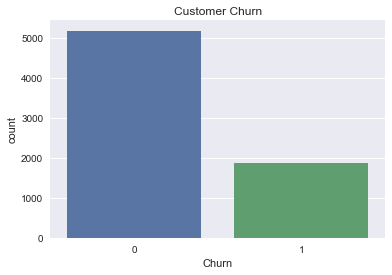

26.5 % of Customers Churn


In [7]:
sns.countplot(x='Churn', data=df)
plt.title('Customer Churn')
plt.show()
print(round(df[df.Churn==1].shape[0]/df.shape[0]*100,1), '% of Customers Churn')

In [8]:
def stackedplot(index, bottom1, top):
    plt.bar(x=index, height=bottom1)
    plt.bar(x=index, height=top, bottom=bottom1)
    plt.text(x=index[0], y=.5*(bottom1[0]),fontsize=15, s='{:.1f}%'.format(bottom1[0]*100/(top[0]+bottom1[0])))
    plt.text(x=index[0], y=.5*(top[0])+bottom1[0],fontsize=15, s='{:.1f}%'.format(top[0]*100/(top[0]+bottom1[0])))
    plt.text(x=index[1], y=.5*(bottom1[1]),fontsize=15, s='{:.1f}%'.format(bottom1[1]*100/(top[1]+bottom1[1])))
    plt.text(x=index[1], y=.5*(top[1])+bottom1[1],fontsize=15, s='{:.1f}%'.format(top[1]*100/(top[1]+bottom1[1])))
    plt.show()

# Comparing Churn Rates in Categorical Variables

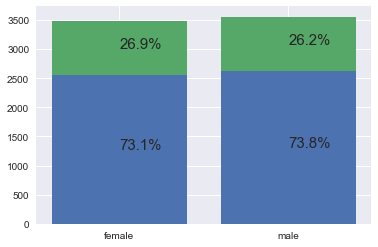

In [9]:
index = ['female', 'male']
bottom1 = [df[(df.female==1)&(df.Churn==0)]['Churn'].count(), df[(df.female==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.female==1)&(df.Churn==1)]['Churn'].count(), df[(df.female==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

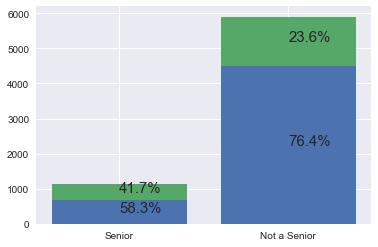

In [10]:
index=['Senior', 'Not a Senior']
bottom1 = [df[(df.SeniorCitizen==1)&(df.Churn==0)]['Churn'].count(), df[(df.SeniorCitizen==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.SeniorCitizen==1)&(df.Churn==1)]['Churn'].count(), df[(df.SeniorCitizen==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

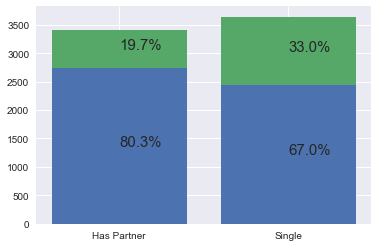

In [11]:
index=['Has Partner', 'Single']
bottom1 = [df[(df.haspartner==1)&(df.Churn==0)]['Churn'].count(), df[(df.haspartner==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.haspartner==1)&(df.Churn==1)]['Churn'].count(), df[(df.haspartner==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

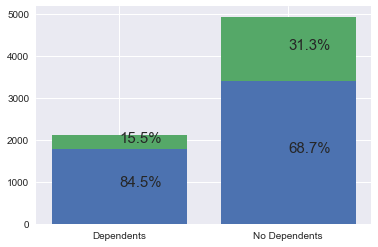

In [12]:
index=['Dependents', 'No Dependents']
bottom1 = [df[(df.hasdependents==1)&(df.Churn==0)]['Churn'].count(), df[(df.hasdependents==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.hasdependents==1)&(df.Churn==1)]['Churn'].count(), df[(df.hasdependents==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

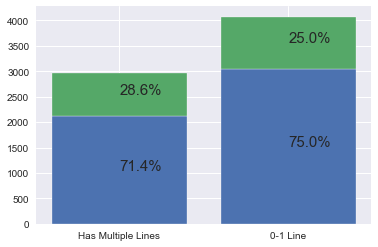

In [70]:
index=['Has Multiple Lines', '0-1 Line']
bottom1 = [df[(df.hasmultlines==1)&(df.Churn==0)]['Churn'].count(), df[(df.hasmultlines==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.hasmultlines==1)&(df.Churn==1)]['Churn'].count(), df[(df.hasmultlines==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

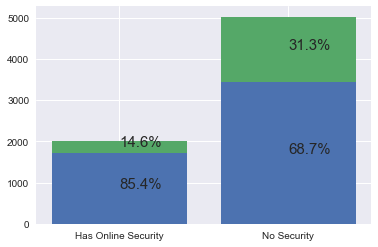

In [14]:
index=['Has Online Security', 'No Security']
bottom1 = [df[(df.hasonlinesec==1)&(df.Churn==0)]['Churn'].count(), df[(df.hasonlinesec==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.hasonlinesec==1)&(df.Churn==1)]['Churn'].count(), df[(df.hasonlinesec==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

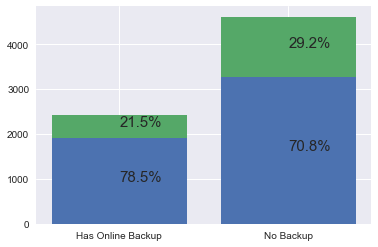

In [15]:
index=['Has Online Backup', 'No Backup']
bottom1 = [df[(df.hasonlinebackup==1)&(df.Churn==0)]['Churn'].count(), df[(df.hasonlinebackup==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.hasonlinebackup==1)&(df.Churn==1)]['Churn'].count(), df[(df.hasonlinebackup==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

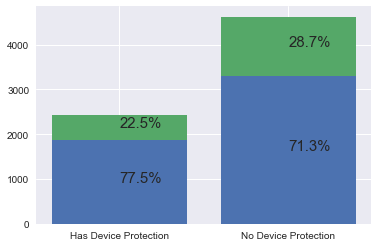

In [16]:
index=['Has Device Protection', 'No Device Protection']
bottom1 = [df[(df.hasdeviceprotection==1)&(df.Churn==0)]['Churn'].count(), df[(df.hasdeviceprotection==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.hasdeviceprotection==1)&(df.Churn==1)]['Churn'].count(), df[(df.hasdeviceprotection==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

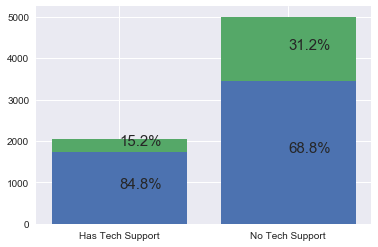

In [17]:
index=['Has Tech Support', 'No Tech Support']
bottom1 = [df[(df.hastechsupport==1)&(df.Churn==0)]['Churn'].count(), df[(df.hastechsupport==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.hastechsupport==1)&(df.Churn==1)]['Churn'].count(), df[(df.hastechsupport==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

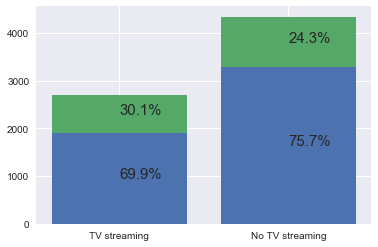

In [18]:
index=['TV streaming', 'No TV streaming']
bottom1 = [df[(df.hasstreamtv==1)&(df.Churn==0)]['Churn'].count(), df[(df.hasstreamtv==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.hasstreamtv==1)&(df.Churn==1)]['Churn'].count(), df[(df.hasstreamtv==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

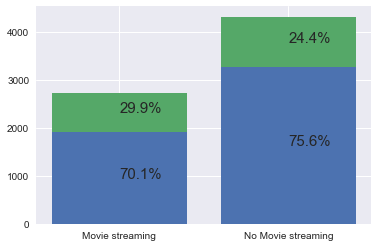

In [19]:
index=['Movie streaming', 'No Movie streaming']
bottom1 = [df[(df.hasstreammovies==1)&(df.Churn==0)]['Churn'].count(), df[(df.hasstreammovies==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.hasstreammovies==1)&(df.Churn==1)]['Churn'].count(), df[(df.hasstreammovies==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

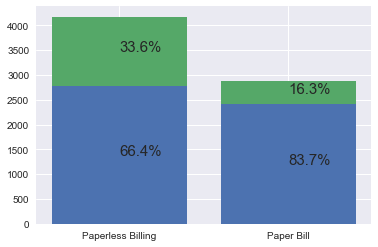

In [20]:
index=['Paperless Billing', 'Paper Bill']
bottom1 = [df[(df.haspaperlessbill==1)&(df.Churn==0)]['Churn'].count(), df[(df.haspaperlessbill==0)&(df.Churn==0)]['Churn'].count()]
top = [df[(df.haspaperlessbill==1)&(df.Churn==1)]['Churn'].count(), df[(df.haspaperlessbill==0)&(df.Churn==1)]['Churn'].count()]
stackedplot(index, bottom1, top)

In [21]:
def pieplots3(outer, label1, label2,label3):
    size = .6
    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(3)*4)
    inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))
    fig, ax = plt.subplots(figsize=(8,8))
    
    ax.pie(outer.sum(axis=1), radius=.8, wedgeprops=dict(width=size, edgecolor='w'), labels=[label1,label2,label3], 
               autopct='%1.1f%%', pctdistance=.9, labeldistance=1.2, colors=outer_colors)

    ax.pie(outer.flatten(), radius=.6, wedgeprops=dict(width=size, edgecolor='w'), 
            labels = ['',str(round(outer[0,1]/(outer[0,1]+outer[0,0])*100,1)) +'%\nChurn','', 
                      str(round(outer[1,1]/(outer[1,1]+outer[1,0])*100,1)) +'%\nChurn','',
                      str(round(outer[2,1]/(outer[2,1]+outer[2,0])*100,1)) +'%\nChurn'],
            colors=inner_colors, labeldistance=.71)
    
    ax.set(aspect='equal', title=label1 + ' Churn Rate')

In [80]:
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,female,haspartner,hasdependents,hasphoneservice,hasmultlines,hasonlinesec,hasonlinebackup,hasdeviceprotection,hastechsupport,hasstreamtv,hasstreammovies,haspaperlessbill
0,0,1,29.85,29.85,0,1,1,0,0,0,0,1,0,0,0,0,1
1,0,34,56.95,1889.50,0,0,0,0,1,0,1,0,1,0,0,0,0
2,0,2,53.85,108.15,1,0,0,0,1,0,1,1,0,0,0,0,1
3,0,45,42.30,1840.75,0,0,0,0,0,0,1,0,1,1,0,0,0
4,0,2,70.70,151.65,1,1,0,0,1,0,0,0,0,0,0,0,1


Text(0.5,1,'Relationship between Payment Method and Churn')

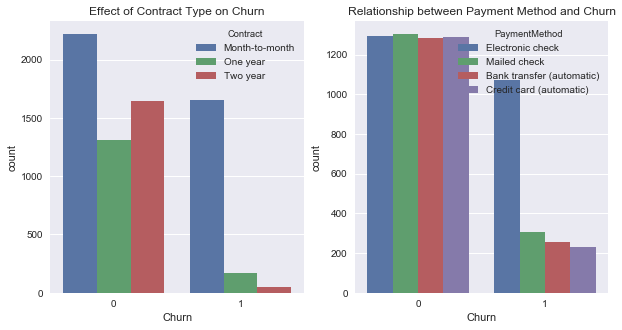

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(df.Churn, hue=df.Contract)
plt.title('Effect of Contract Type on Churn')
plt.subplot(1,2,2)
sns.countplot(df.Churn, hue=df.PaymentMethod)
plt.title('Relationship between Payment Method and Churn')

Month-month plans are more popular than the contract options for both demographics. However customers who churn are much more likely to be have a monthly plan. Looking at the payment methods graph, the four methods of payment are pretty evenly utlized by the customers who stay with the company. The group of customers who churn disproportionately choose to pay with electronic check. Unsurprisingly, the two automatic payment options are least frequently used. Below, we'll look at how the relationship between continuous variables and churn.

C:\Users\JChaotogo\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


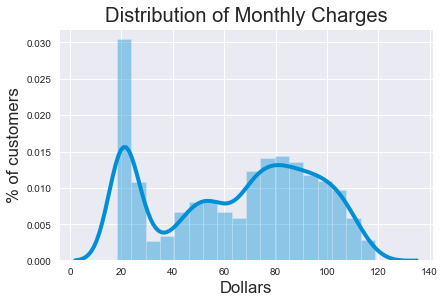

In [78]:
sns.distplot(df.MonthlyCharges)
plt.ylabel('% of customers')
plt.xlabel('Dollars')
plt.title('Distribution of Monthly Charges')
plt.show()

Text(0.5,1,'Tenure of Churn vs Retained Customers')

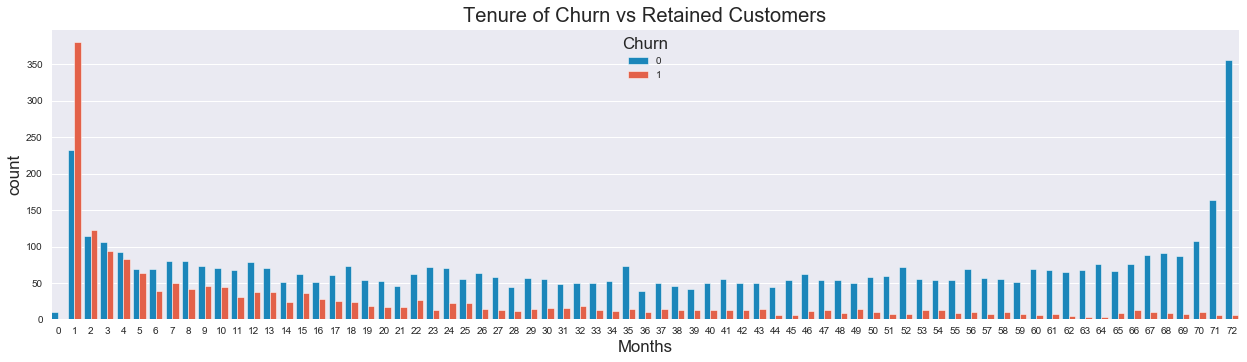

In [77]:
sns.set_style("darkgrid")
plt.figure(figsize=(19,5))
sns.countplot(df['tenure'], hue=df.Churn)
plt.xlabel('Months')
plt.title('Tenure of Churn vs Retained Customers')

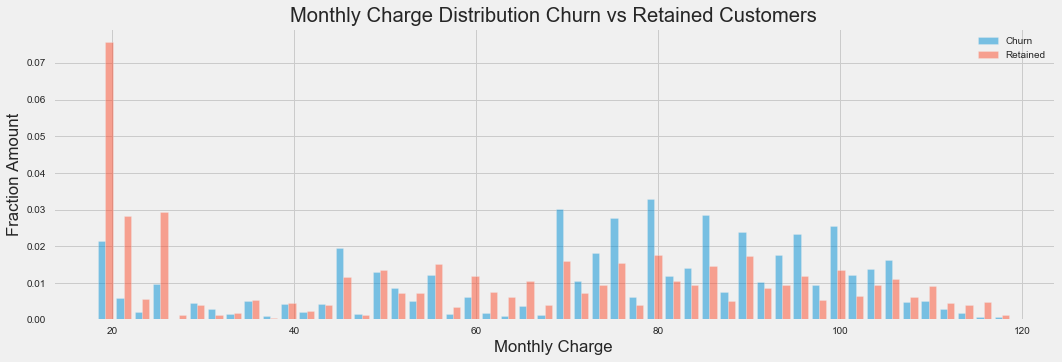

In [73]:
churny = df[df.Churn==1]
churnn = df[df.Churn==0]
plt.figure(figsize=(16,5))
plt.hist([churny['MonthlyCharges'], churnn['MonthlyCharges']], alpha=.5, bins=50, density=True)
plt.legend(['Churn', 'Retained'])
plt.ylabel('Fraction Amount')
plt.xlabel('Monthly Charge')
plt.title('Monthly Charge Distribution Churn vs Retained Customers')
plt.show()

# Feature Engineering

We're going to choose churn as the target feature. The 3 continuous features are tenure, monthly charge, and total charge, the other features we will get from the various categorical variables.

In [26]:
dummies = pd.get_dummies(df[['Contract', 'PaymentMethod','InternetService']])
df.drop(columns=['InternetService','Contract','PaymentMethod'], inplace=True)

In [27]:
features = pd.concat([dummies, df], axis=1, join='outer')

In [28]:
features.columns

Index(['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'female', 'haspartner', 'hasdependents',
       'hasphoneservice', 'hasmultlines', 'hasonlinesec', 'hasonlinebackup',
       'hasdeviceprotection', 'hastechsupport', 'hasstreamtv',
       'hasstreammovies', 'haspaperlessbill'],
      dtype='object')

Text(0.5,1,'Correlation Matrix of Features')

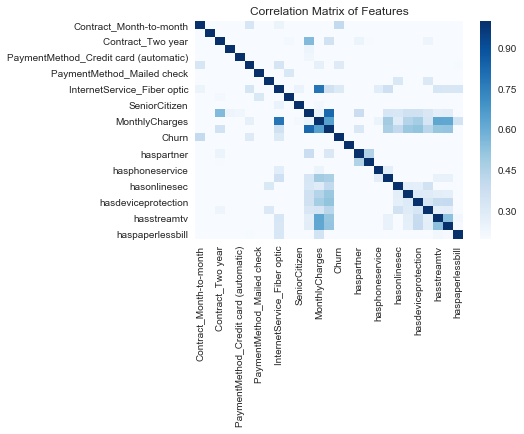

In [29]:
sns.heatmap(features.corr(), vmin=.2, cmap = 'Blues')
plt.title('Correlation Matrix of Features')

In [30]:
#Create the training and test sets.
X=features.drop(columns=['Churn', 'TotalCharges'])
Y=features['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.3, random_state=0)

# Trial 1 -  Logistic Regression

In [31]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
print('Training ACC score:', lgr.score(X_train, y_train))
print(' Testing ACC score:', lgr.score(X_test, y_test))
predy = lgr.predict(X_test)
print('\nCross-Tab\n',confusion_matrix(y_test, predy))
print('\nClassification Report\n', classification_report(y_test, predy))

Training ACC score: 0.8024340770791075
 Testing ACC score: 0.8017037387600567

Cross-Tab
 [[1398  162]
 [ 257  296]]

Classification Report
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1560
           1       0.65      0.54      0.59       553

   micro avg       0.80      0.80      0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.80      2113



C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Our first log model gave us a precision of 80% but because of the large class imbalance, the f1-score for the correctly predicting churn customers was rather low at 59%. We can attempt to get a better score by tuning the parameters a bit using GridSearchCV.

# Trial 1 - RFC

In [32]:
start=time.time()
rfc = RandomForestClassifier(n_jobs=-1, max_depth=9, n_estimators=900)
rfc.fit(X_train,y_train)
print(rfc.score(X_train,y_train))
print(rfc.score(X_test,y_test))
predrfc = rfc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predrfc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predrfc))
print(cross_val_score(rfc, X, Y, cv=5))
print(time.time()-start)

0.8525354969574036
0.8002839564600095
Cross-Tab

 Churn     0    1
row_0           
0      1405  267
1       155  286

Classification Report

               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1560
           1       0.65      0.52      0.58       553

   micro avg       0.80      0.80      0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113

[0.80979418 0.80624556 0.78211498 0.80908446 0.79673063]
23.77695631980896


# Trial 1 -  XGBoost Classifier

In [33]:
X_train = scipy.sparse.csc_matrix(X_train)
X_test = scipy.sparse.csc_matrix(X_test)
start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
                    max_depth = 9, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))
predxgb = xgb.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predxgb, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predxgb))
print(cross_val_score(xgb, X, Y, n_jobs=-1, cv=5))
print(time.time()-start)

0.9963488843813387
0.77520113582584
Cross-Tab

 Churn     0    1
row_0           
0      1344  259
1       216  294

Classification Report

               precision    recall  f1-score   support

           0       0.84      0.86      0.85      1560
           1       0.58      0.53      0.55       553

   micro avg       0.78      0.78      0.78      2113
   macro avg       0.71      0.70      0.70      2113
weighted avg       0.77      0.78      0.77      2113

[0.77004968 0.77146913 0.75514549 0.77714691 0.78678038]
5.139390707015991


# Trial 1 - SVC

start=time.time()
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)
print(svc.score(X_train, y_train))
print(svc.score(X_test, y_test))
predsvc=svc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predsvc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predsvc))
#print(cross_val_score(svc, X, Y, n_jobs=-1, cv=3))
print(time.time()-start)
#This classifier took nearly 2 hours to load...Going to pickle it
save_classifier = open('svctrial1.pickle','wb')
pickle.dump(svc, save_classifier)
save_classifier.close()

# Trial 1 - KNN

In [34]:
knn = KNeighborsClassifier(weights='distance')
knn.fit(X_train, y_train)
predknn = knn.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predknn, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predknn))
print(cross_val_score(knn, X, Y, n_jobs=-1, cv=5))

Cross-Tab

 Churn     0    1
row_0           
0      1355  260
1       205  293

Classification Report

               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1560
           1       0.59      0.53      0.56       553

   micro avg       0.78      0.78      0.78      2113
   macro avg       0.71      0.70      0.71      2113
weighted avg       0.77      0.78      0.78      2113

[0.77430802 0.78992193 0.761533   0.75727466 0.77540867]


# First Run Analysis
The classifiers we trained are good at predicting negative churn; however, the classifier performs poorly on predicting churn. This is most likely caused by the class imbalance which incentivizes the model to predict negative churn more often. Originally, my thought was that 25% postive and 75% negative data would be sufficient as the positive class was still sufficiently large. But based on the recall scores, we can see that the model has a high false negative rate. In the next steps, I will try to improve the sensitivity of the model by artificially balancing the classes.

# Trial 2 - Applying SMOTE

In [35]:
#Use SMOTE to oversample the minority class.
sm = SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [36]:
lgr = LogisticRegression(penalty='l1', C=100)
lgr.fit(X_train_smote, y_train_smote)
print(lgr.score(X_train_smote, y_train_smote))
print(lgr.score(X_test, y_test))
predy = lgr.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predy, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predy))

0.8653846153846154
0.8031235210601041
Cross-Tab

 Churn     0    1
row_0           
0      1398  254
1       162  299

Classification Report

               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1560
           1       0.65      0.54      0.59       553

   micro avg       0.80      0.80      0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.80      2113



C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [37]:
#Try RFC
start=time.time()
rfc = RandomForestClassifier(n_jobs=-1, max_depth=7, n_estimators=900)
rfc.fit(X_train_smote,y_train_smote)
print(rfc.score(X_train_smote,y_train_smote))
print(rfc.score(X_test,y_test))
predrfc = rfc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predrfc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predrfc))
print(time.time()-start)

0.8765910348644161
0.7993374349266446
Cross-Tab

 Churn     0    1
row_0           
0      1427  291
1       133  262

Classification Report

               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1560
           1       0.66      0.47      0.55       553

   micro avg       0.80      0.80      0.80      2113
   macro avg       0.75      0.69      0.71      2113
weighted avg       0.79      0.80      0.79      2113

3.9337124824523926


In [38]:
X_train_smote = scipy.sparse.csc_matrix(X_train_smote)
X_test = scipy.sparse.csc_matrix(X_test)
start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                    max_depth = 3, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train_smote, y_train_smote)
print(xgb.score(X_train_smote, y_train_smote))
print(xgb.score(X_test, y_test))
predxgb = xgb.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predxgb, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predxgb))
print(cross_val_score(xgb, X, Y, n_jobs=-1, cv=3))
print(time.time()-start)

0.87825124515772
0.79649787032655
Cross-Tab

 Churn     0    1
row_0           
0      1387  257
1       173  296

Classification Report

               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1560
           1       0.63      0.54      0.58       553

   micro avg       0.80      0.80      0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113

[0.8109029  0.8032368  0.80187473]
1.3254518508911133


In [39]:
knn = KNeighborsClassifier(weights='distance', algorithm='auto')
knn.fit(X_train_smote, y_train_smote)
predknn = knn.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predknn, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predknn))
print(cross_val_score(knn, X, Y, n_jobs=-1, cv=5))

Cross-Tab

 Churn     0    1
row_0           
0      1356  259
1       204  294

Classification Report

               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1560
           1       0.59      0.53      0.56       553

   micro avg       0.78      0.78      0.78      2113
   macro avg       0.71      0.70      0.71      2113
weighted avg       0.77      0.78      0.78      2113

[0.77430802 0.78992193 0.761533   0.75727466 0.77540867]


start=time.time()
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train_smote, y_train_smote)
print(svc.score(X_train_smote, y_train_smote))
print(svc.score(X_test, y_test))
predsvc=svc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predsvc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predsvc))
#print(cross_val_score(svc, X, Y, n_jobs=-1, cv=10))
print(time.time()-start)
#This classifier took nearly 2 hours to load...Going to pickle it
save_classifier = open('svc1.pickle','wb')
pickle.dump(svc, save_classifier)
save_classifier.close()

# Trial 3 - PCA

In [40]:
scaler = StandardScaler()
scaled = scaler.fit_transform(features[['MonthlyCharges', 'tenure']])
scaled = pd.DataFrame(scaled, columns = ['MonthlyCharges', 'tenure'])
features2 = features.drop(columns=['MonthlyCharges', 'tenure'])
features2 = features2.merge(scaled, left_index=True, right_index=True, how='left')

C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [41]:
Xscaled = features2.drop(columns='Churn')
Yscaled = features2['Churn']
pca = PCA(n_components=15)
Xscaled = pca.fit_transform(Xscaled)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled, Yscaled, test_size = .3, random_state=0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [43]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
print('Training ACC score:', lgr.score(X_train, y_train))
print(' Testing ACC score:', lgr.score(X_test, y_test))
predy = lgr.predict(X_test)
print('\nCross-Tab\n',confusion_matrix(y_test, predy))
print('\nClassification Report\n', classification_report(y_test, predy))

Training ACC score: 0.7782235749861649
 Testing ACC score: 0.754850922858495

Cross-Tab
 [[1168  392]
 [ 126  427]]

Classification Report
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1560
           1       0.52      0.77      0.62       553

   micro avg       0.75      0.75      0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.77      2113



C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [57]:
X_train = scipy.sparse.csc_matrix(X_train)
X_test = scipy.sparse.csc_matrix(X_test)
start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
                    max_depth = 3, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))
predxgb = xgb.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predxgb, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predxgb))
print(cross_val_score(xgb, X, Y, n_jobs=-1, cv=5))
print(time.time()-start)

0.8244327614831212
0.7576904874585897
Cross-Tab

 Churn     0    1
row_0           
0      1187  139
1       373  414

Classification Report

               precision    recall  f1-score   support

           0       0.90      0.76      0.82      1560
           1       0.53      0.75      0.62       553

   micro avg       0.76      0.76      0.76      2113
   macro avg       0.71      0.75      0.72      2113
weighted avg       0.80      0.76      0.77      2113

[0.8133428  0.80908446 0.78850248 0.80695529 0.7981521 ]
1.447596549987793


In [45]:
start=time.time()
rfc = RandomForestClassifier(n_jobs=-1, max_depth=9, n_estimators=600)
rfc.fit(X_train,y_train)
print(rfc.score(X_train,y_train))
print(rfc.score(X_test,y_test))
predrfc = rfc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predrfc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predrfc))
#print(cross_val_score(rfc, X, Y, cv=5))
print(time.time()-start)

0.8941615938018815
0.7685754850922859
Cross-Tab

 Churn     0    1
row_0           
0      1220  149
1       340  404

Classification Report

               precision    recall  f1-score   support

           0       0.89      0.78      0.83      1560
           1       0.54      0.73      0.62       553

   micro avg       0.77      0.77      0.77      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.77      0.78      2113

9.196402072906494


In [46]:
knn = KNeighborsClassifier(weights='distance')
knn.fit(X_train, y_train)
predknn = knn.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predknn, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predknn))
print(cross_val_score(knn, X, Y, n_jobs=-1, cv=5))

Cross-Tab

 Churn     0    1
row_0           
0      1029  221
1       531  332

Classification Report

               precision    recall  f1-score   support

           0       0.82      0.66      0.73      1560
           1       0.38      0.60      0.47       553

   micro avg       0.64      0.64      0.64      2113
   macro avg       0.60      0.63      0.60      2113
weighted avg       0.71      0.64      0.66      2113

[0.77430802 0.78992193 0.761533   0.75727466 0.77540867]


In [47]:
start=time.time()
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)
print(svc.score(X_train, y_train))
print(svc.score(X_test, y_test))
predsvc=svc.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predsvc, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predsvc))
#print(cross_val_score(svc, X, Y, n_jobs=-1, cv=3))
print(time.time()-start)
#This classifier took nearly 2 hours to load...Going to pickle it
save_classifier = open('svcpca.pickle','wb')
pickle.dump(svc, save_classifier)
save_classifier.close()

0.7649418926397343
0.7557974443918599
Cross-Tab

 Churn     0    1
row_0           
0      1194  150
1       366  403

Classification Report

               precision    recall  f1-score   support

           0       0.89      0.77      0.82      1560
           1       0.52      0.73      0.61       553

   micro avg       0.76      0.76      0.76      2113
   macro avg       0.71      0.75      0.72      2113
weighted avg       0.79      0.76      0.77      2113

9390.742170095444


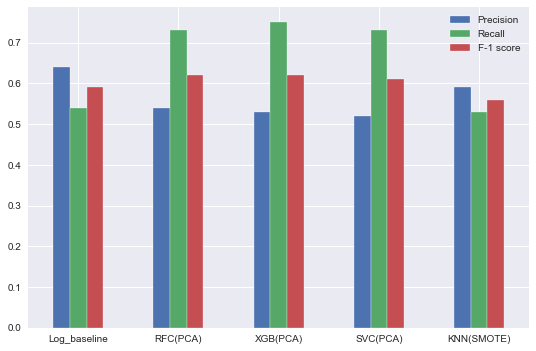

In [83]:
#Best model performances
model = ['Log_baseline', 'RFC(PCA)', 'XGB(PCA)', 'SVC(PCA)', 'KNN(SMOTE)']
precision = [.64, .54, .53, .52, .59]
recall = [.54,.73,.75,.73,.53]
f1score = [.59,.62,.62,.61,.56]

models = pd.DataFrame(np.c_[precision, recall, f1score], index=model)
ax = models.plot.bar(rot=0)
ax.legend(['Precision', 'Recall', 'F-1 score'])
plt.show()